In [13]:
import sys
sys.path.append('..')

# Hyperparameters and validation sets

## Prerequisites
- [Bias, variance and generalisation]()
- [Gradient based optimisation]()

## Learning objectives
- understand what hyperparameters are
- understand what validation sets are, why we need them and how we use them

Start by running the code cell below. It will create a random polynomial function which we will try to model, and also sample some data from it which will be examples in our dataset which we can train and test our model on.

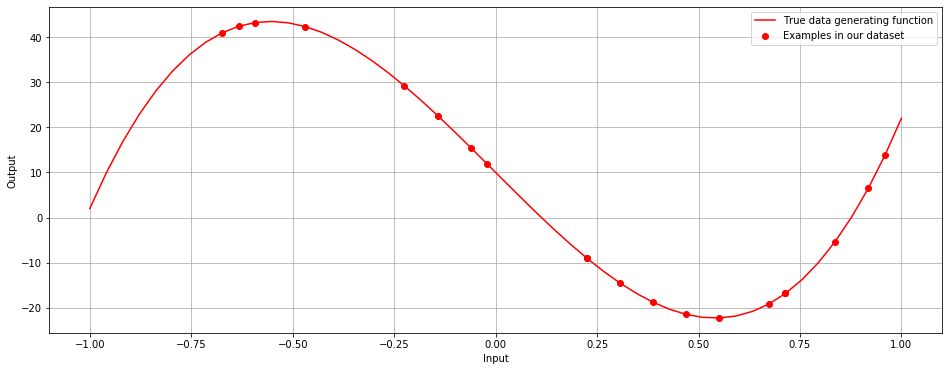

In [14]:
import torch
import numpy
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import numpy as np

_range = 1
all_possible_inputs = np.linspace(-_range, _range, 50) # create a range of inputs 
m = 20 # how many examples do we want?
dataset = np.random.choice(all_possible_inputs, size=(m,)) # here we randomly sample some inputs from the true data
true_coeffs = (10, -90, 2, 100) # coefficients of our data generating function
Y_fn = np.polynomial.polynomial.Polynomial(true_coeffs) # create a polynomial data generating function with these coefficients
Y = Y_fn(dataset) # evaluate our data generating function on these inputs

fig = plt.figure(figsize=(16, 6))
plt.scatter(dataset, Y, c='r', label='Examples in our dataset')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='True data generating function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

## Let's split our dataset into training and testing sets 

Sklearn has a module called `model selection` which is made for evaluating models.
The starting point for any model evaluation is splitting our dataset into a training set and a test set.
The module has a function called `train_test_split` which does this for us.

It has a keyword argument `test_size` which is the proportion of the dataset which will end up in the test set.
Its default value is 0.25.

It has a keyword argument `shuffle` which if true shuffles the dataset before splitting to produce random splits.
By default, its value is true.

Check out the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) here.

len total dataset: 20
len train_set: 15
len test_set: 5


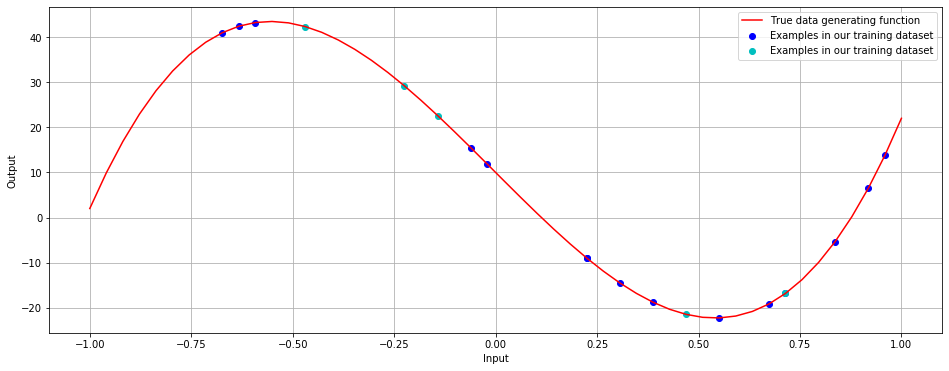

In [15]:
from sklearn.model_selection import train_test_split

print('len total dataset:', len(dataset))

train_data, test_data = train_test_split(dataset, test_size=0.25, shuffle=True) ## randomly split data into train and validation sets

print('len train_set:', len(train_data))
print('len test_set:', len(test_data))

plt.figure(figsize=(16, 6))
plt.scatter(train_data, Y_fn(train_data), c='b', label='Examples in our training dataset')
plt.scatter(test_data, Y_fn(test_data), c='c', label='Examples in our training dataset')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='True data generating function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

## Let's train a polynomial model that performs multivariate regression and test it's performance.

The code below creates a polynomial model of the form:

## $y = b + w_1 x + w_2 x^2 + ... + w_n x^n$

The loss function which it optimises is the mean squared error loss function:

## $L = \frac{1}{m}\sum_{i=1}^m(\hat{y} - y)^2$

where $w_i$ is the ith weight of the model not including the bias, $b$.

We've done this before, so just run the cell below.

TEST LOSS: 5.402353470584979


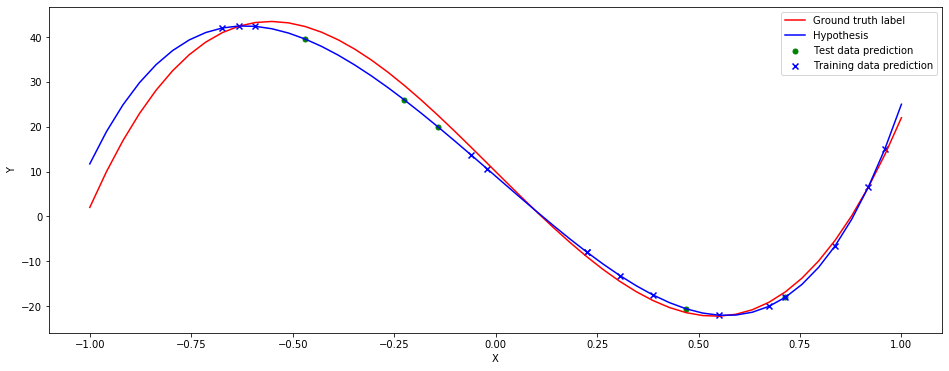

In [16]:
class MultiVariableLinearHypothesis:
    def __init__(self, n_features):
        self.n_features = n_features
        self.b = np.random.randn()
        self.w = np.random.randn(n_features)

    def __call__(self, X): # input is of shape (n_datapoints, n_vars)
        y_hat = np.matmul(X, self.w) + self.b
        return y_hat # output is of shape (n_datapoints, 1)

    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b
        
    def calc_deriv(self, X, y_hat, labels):
        diffs = y_hat - labels # calculate error
        dLdw = 2 / m * np.matmul(X.T, diffs) # derivative of MSE term of loss wrt w
        dLdb = 2 * np.mean(diffs) # derivative of MSE term of loss wrt w
        return dLdw, dLdb
            
def train(num_epochs, X, Y, H, learning_rate):
    for e in range(num_epochs): # for this many complete runs through the dataset
        y_hat = H(X) # make predictions
        dLdw, dLdb = H.calc_deriv(X, y_hat, Y) # calculate gradient of current loss with respect to model parameters
        new_w = H.w - learning_rate * dLdw # compute new model weight using gradient descent update rule
        new_b = H.b - learning_rate * dLdb # compute new model bias using gradient descent update rule
        H.update_params(new_w, new_b) # update model weight and bias
        
def test(X, Y, H):
    y_hat = H(X) ## make predictions
    loss = np.sum((y_hat - Y)**2) / len(Y) # calculate mean squared error
    return loss
                           
def create_polynomial_inputs(X, order=3):
    new_dataset = np.array([X, *[np.power(X, i) for i in range(2, order + 1)]]).T # add higher order powers of X to design matrix''
        # ^ equivalent to:
        # new_dataset = [X] # initially the dataset just has X in
        # for i in range(2, order + 1): # add polynomial terms from 2 and upward (inclusive of specified order)
            # new_order_of_feature = np.power(X, i) # raise to new order
            # new_dataset.append(new_order_of_feature) # append new order of features to dataset
        # new_dataset = np.array(new_dataset) # convert to np array
    return new_dataset # new_dataset should be shape [m, order]

num_epochs = 10000
learning_rate = 0.1
highest_order_power = 5 # change this to adjust the model
weight_decay = 0

X_train = create_polynomial_inputs(train_data, highest_order_power) # create polynomial inputs from train data
Y_train = Y_fn(train_data)
H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    
train(num_epochs, X_train, Y_train, H, learning_rate) # train model and plot cost curve

X_test = create_polynomial_inputs(test_data, highest_order_power) # create polynomial inputs from train data
Y_test = Y_fn(test_data)
loss = test(X_test, Y_test, H)
print('TEST LOSS:', loss)

fig = plt.figure(figsize=(16, 6))
# plt.scatter(dataset, Y_fn(dataset), c='r', label='Label')

plt.scatter(test_data, H(X_test), c='g', label='Test data prediction', marker='.', s=100)
plt.scatter(train_data, H(X_train), c='b', label='Training data prediction', marker='x')

# PLOT GROUND TRUTH FOR ALL VALUES OF X ACROSS DOMAIN
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='Ground truth label')

# PLOT PREDICTIONS FOR ALL VALUES OF X ACROSS DOMAIN
plt.plot(all_possible_inputs, H(create_polynomial_inputs(all_possible_inputs, highest_order_power)), c='b', label='Hypothesis')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Hyperparameters

You've probably already asked questions along the lines of "What batch size should I use?", "What learning rate should I use?", "What polynomial terms should my model include?".

The batch size, learning rate and model architecture are all examples of **hyperparameters**. 
They are not optimised by the learning algorithm itself.

Most commonly, a parameter is chosen to be a hyperparameter becuase optimising this parameter on the training set is not appropriate. 
For example, the number of polynomial terms in a model is a hyperparameter. 
This is because a model with more polynomial terms means a model with greater capacity. 
So if optimised directly, the optimal value is as large as possible (so that the model can represent more functions). 
This would lead to the model overfitting. 
As such, any parameters that control the capacity of a model should be hyperparameters. 

Other times, a parameter may be chosen to be a hyperparameter if is challenging to optimise. For example, the batch size. The batch size is challenging to optimise because you will need to fully train and test many different models to compare how changing it affects the final loss on the test set.

## Why should we not tune our hyperparameters based on our model's score on the test set?

Previously we have split our data into train and test sets. The test set is for estimating how well our model  will generalise to perform well on unseen examples. It is important that we do not use the test set to make any decisions about the model. If we do, our model would be overfit to the test set because we are both training and testing our hyperparameters on the test data.

You may find that a certain set of hyperparameters perform well on the test set, but then fail to perform as well in the wild when the model is being evaluated on other unseen examples because the hyperparameters that you selected were optimised for *this* test data. 

## What else can we tune them on? 

Just like we previously split our data into train and test sets. We can split our train set into a final train set and **validation set**. 

We can then use this split-off validation dataset to validate that the current hyperparameters will make our model to perform well on unseen data - both the validation set and the test set are unseen.

## Generalisation error
The model's ability to perform well on the validation set determines how well it will generalise to unseen examples.
As such, we call the loss attained on the validation set **generalisation error**.

In [17]:
print('len of initial train set', len(train_data))
train_data, val_data = train_test_split(train_data, test_size=0.5, shuffle=True) ## randomly split data into train and validation sets

print('len of remaining train_set:', len(train_data))
print('len val_set:', len(val_data))

X_val = create_polynomial_inputs(val_data, highest_order_power) # create polynomial inputs from train data
Y_val = Y_fn(val_data)

def validate(X, Y, H):
    y_hat = H(X) # make predictions
    loss = np.mean((y_hat - Y)**2) # calculate mean squared error
    return loss

len of initial train set 15
len of remaining train_set: 7
len val_set: 8


## Let's implement a grid search to optimise our hyperparameters

Let's systematically try out a range of different learning rates and number of polynomial terms in our model.

In [22]:
# HERE ARE SOME HYPERPARAMETERS THAT WE WILL OPTIMISE
learning_rates = [0.0001, 0.001, 0.01, 0.1]
highest_order_powers = list(range(1, 10))

losses = np.zeros((len(learning_rates), len(highest_order_powers))) ## initialise a tensor of zeros to store the losses for each hyperparameterisation
for pow_idx, highest_order_power in enumerate(highest_order_powers): ## for each highest order power that we want to test
    
    X_train = create_polynomial_inputs(train_data, highest_order_power) # create polynomial inputs in training set
    Y_train = Y_fn(train_data)
    
    X_val = create_polynomial_inputs(val_data, highest_order_power) # create polynomial inputs in validation set
    Y_val = Y_fn(val_data)
    
    H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    for lr_idx, lr in enumerate(learning_rates): ## for each learning rate
        train(num_epochs, X_train, Y_train, H, lr) ## train the model
        loss = validate(X_val, Y_val, H) ## get the validation loss 
#         print(f'Weight_decay: {weight_decay}\t\tHighest order power: {highest_order_power}\t\tLoss: {loss}')
        losses[lr_idx][pow_idx] = loss ## save this validation loss in the corresponding index of our grid of losses

Run the cell below to visualise these parameterisations in 3d.

In [23]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

norm = plt.Normalize(losses.min(), losses.max())
colors = cm.viridis(norm(losses))
rcount, ccount, _ = colors.shape

%matplotlib 

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
best_lr_idx, best_order_idx = np.unravel_index(losses.argmin(), losses.shape)
print(losses.shape)
print(losses)
print('best lr idx:', best_lr_idx)
print('best order idx:', best_order_idx)
best_lr = learning_rates[best_lr_idx]
best_order = highest_order_powers[best_order_idx]
print('best lr:', best_lr)
print('best power:', best_order)
ax.plot([best_lr, best_lr], [best_order, best_order], [0, losses.max()], c='#ff822e', label='Optimal hyperparameters')
lrs, pows = np.meshgrid(highest_order_powers, learning_rates)
print(lrs.shape)
print(pows.shape)
print(losses.shape)
s = ax.plot_surface(pows, lrs, losses, cmap=cm.copper, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Highest order power')
ax.set_zlabel('Validation Loss')
plt.legend()
plt.show()

Using matplotlib backend: GTK3Agg
(4, 9)
[[550.96945873 533.39164964 540.94142147 552.39929932 531.3045909
  559.57829905 547.67086928 576.82436312 547.91406549]
 [382.30957707 319.71808901 352.84870373 311.67186648 307.68407819
  302.68773425 291.25148578 296.5289628  266.83414902]
 [410.47085949 160.30101464  98.79538119  55.28197219  28.5151603
   18.72870779  14.0995535   15.57440818  21.12236299]
 [410.47086696 156.2495844    0.63729203   5.20334605  16.04223444
   23.27182117  30.2145614   29.69007833  31.55421899]]
best lr idx: 3
best order idx: 2
best lr: 0.1
best power: 3
(4, 9)
(4, 9)
(4, 9)


Here is an example of a loss surface over a hyperparameter search:
![](images/hyperparameters_search.png)

## Summary
- hyperparameters are parameters of our algorithm that don't make sense to optimise directly
    - either because they are difficult to optimise because they need to be tested across many different trained models
    - or because they 
- a validation set is another subset of our whole dataset alongside our training and test sets
- hyperparameters can be tuned by evaluating performance on the validation set because this tests their generalisation without biasing performance, which would be evaluated on the test set
- hyperparameters should not be tuned on the test set because this is prone to overfitting

### Challenges
- Implement a genetic hyperparameter search